In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../hovernet')
sys.path.append('../deconvplugin')

import json
import os
import pickle
import torch
import scanpy as sc

PATH = '/home/luca/Documents/data/'

#'/cluster/CBIO/data1/lgortana/'
#'/home/luca/Documents/data/'

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [1]:
# names
adata_name = 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma'
sim_tag = "6_moco_clusters_700spots_040101010101_15mean_15var"
model_tag = "alpha_0_lr_0.0001_weights_False_divergence_kl_sim_040101010101_resnet18_fulltrain"

# alpha_0_lr_0.0001_weights_False_divergence_kl_sim_010104010101_resnet18_fulltrain

In [3]:
import pandas as pd

data_path = os.path.join(PATH, adata_name)
sim_path = os.path.join(data_path, "sim")

#load image_dict
image_dict = torch.load(os.path.join(sim_path, f'{sim_tag}_image_dict_64.pt'))

#load ground truth
ground_truth = pd.read_csv(os.path.join(sim_path, f'{sim_tag}_gt.csv'), index_col=0)
ground_truth.index = ground_truth.index.astype(str)

In [126]:
#load model infos
model_dir = os.path.join('../models', model_tag)

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

In [132]:
from deconvplugin.analysis.pred_analyzer import PredAnalyzer

analyzer = PredAnalyzer(model_info=model_info,
                        model_state="best",
                        adjusted=True,
                        ground_truth=ground_truth, 
                        image_dict=image_dict
                        )

Loading predicted labels...
Loading true labels...
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


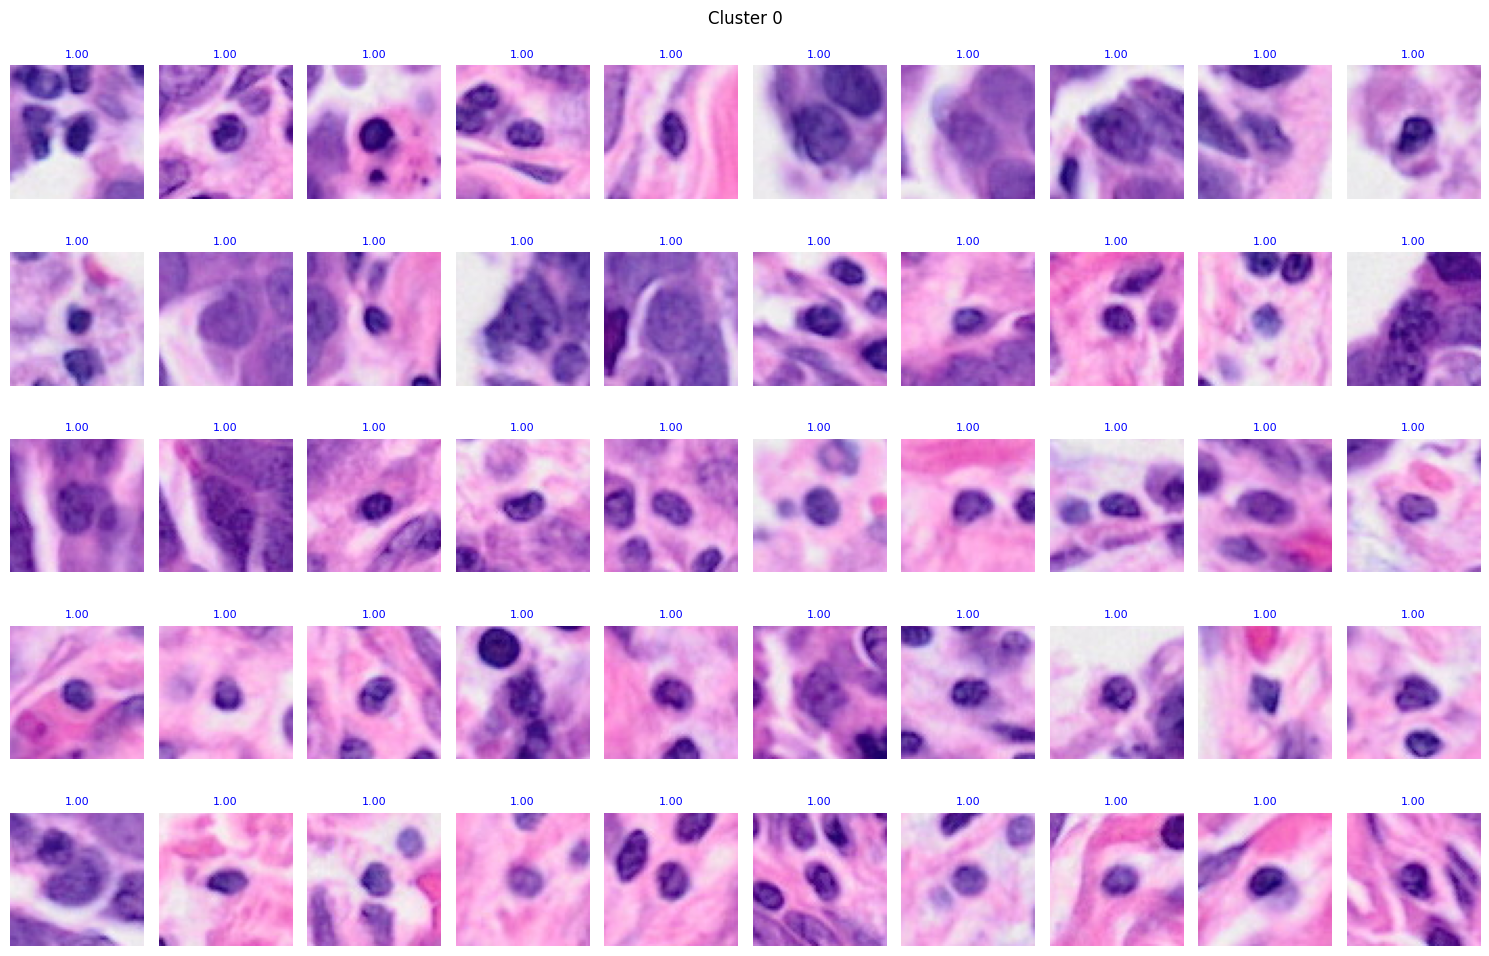

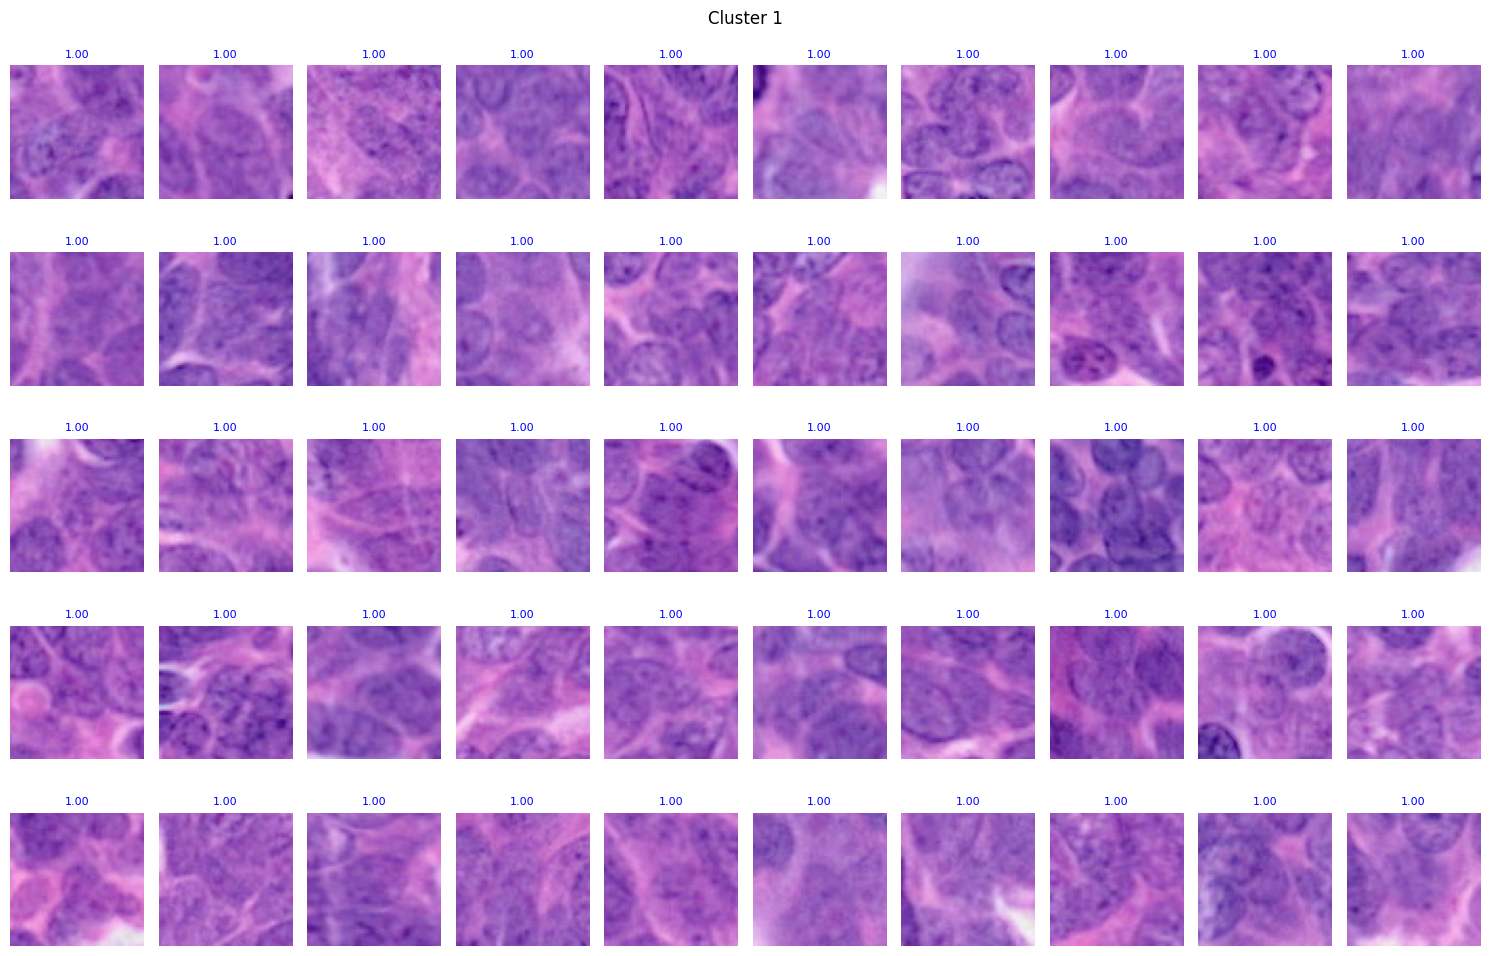

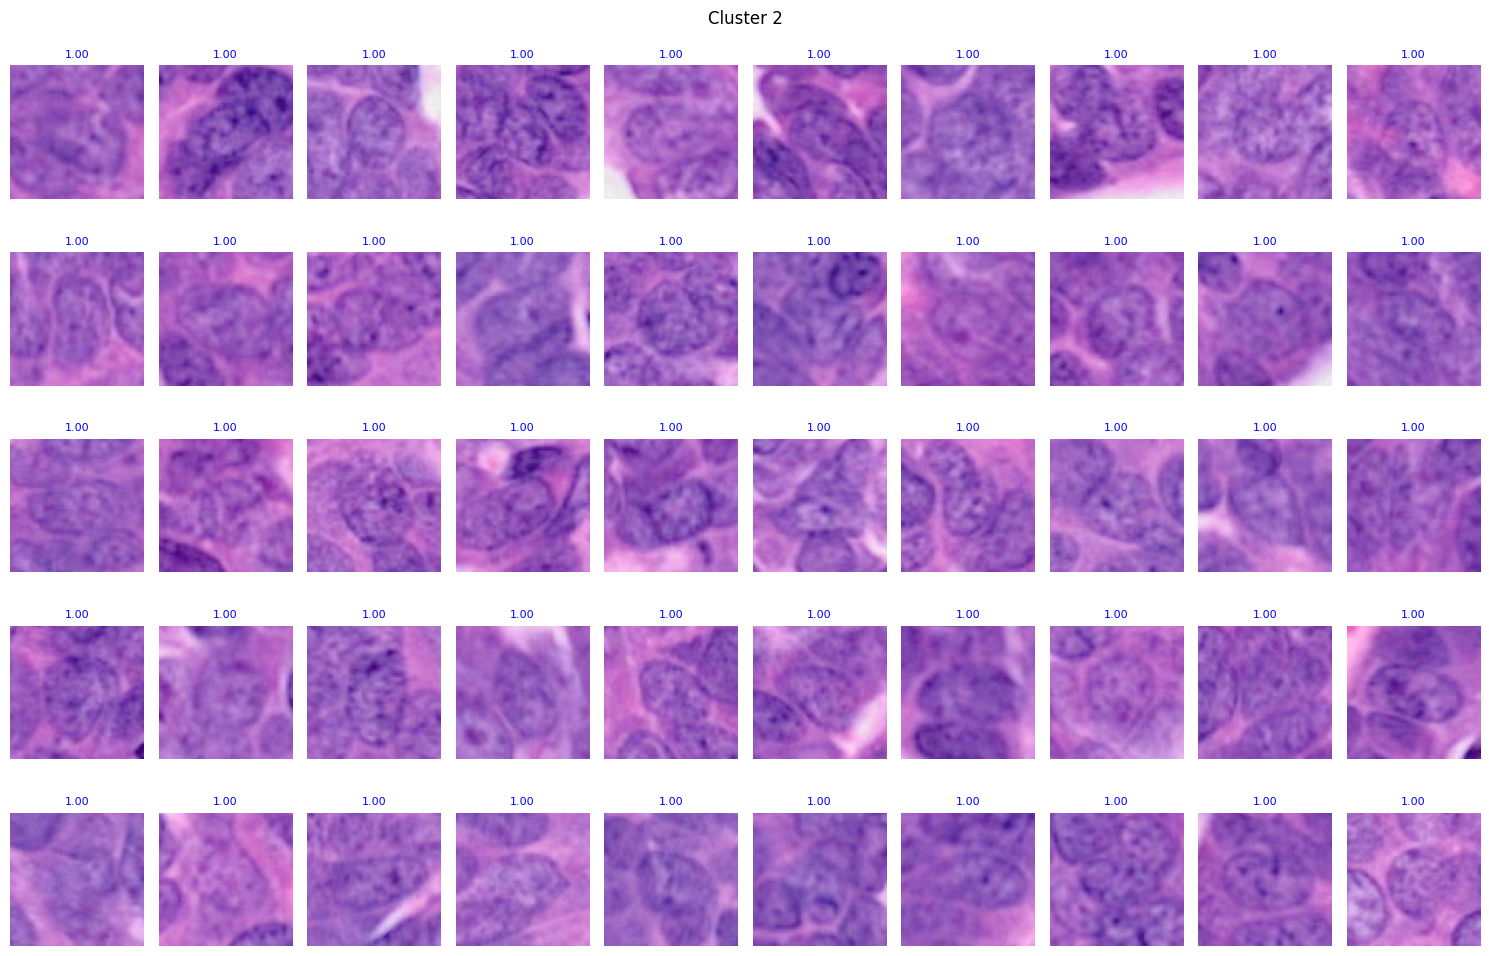

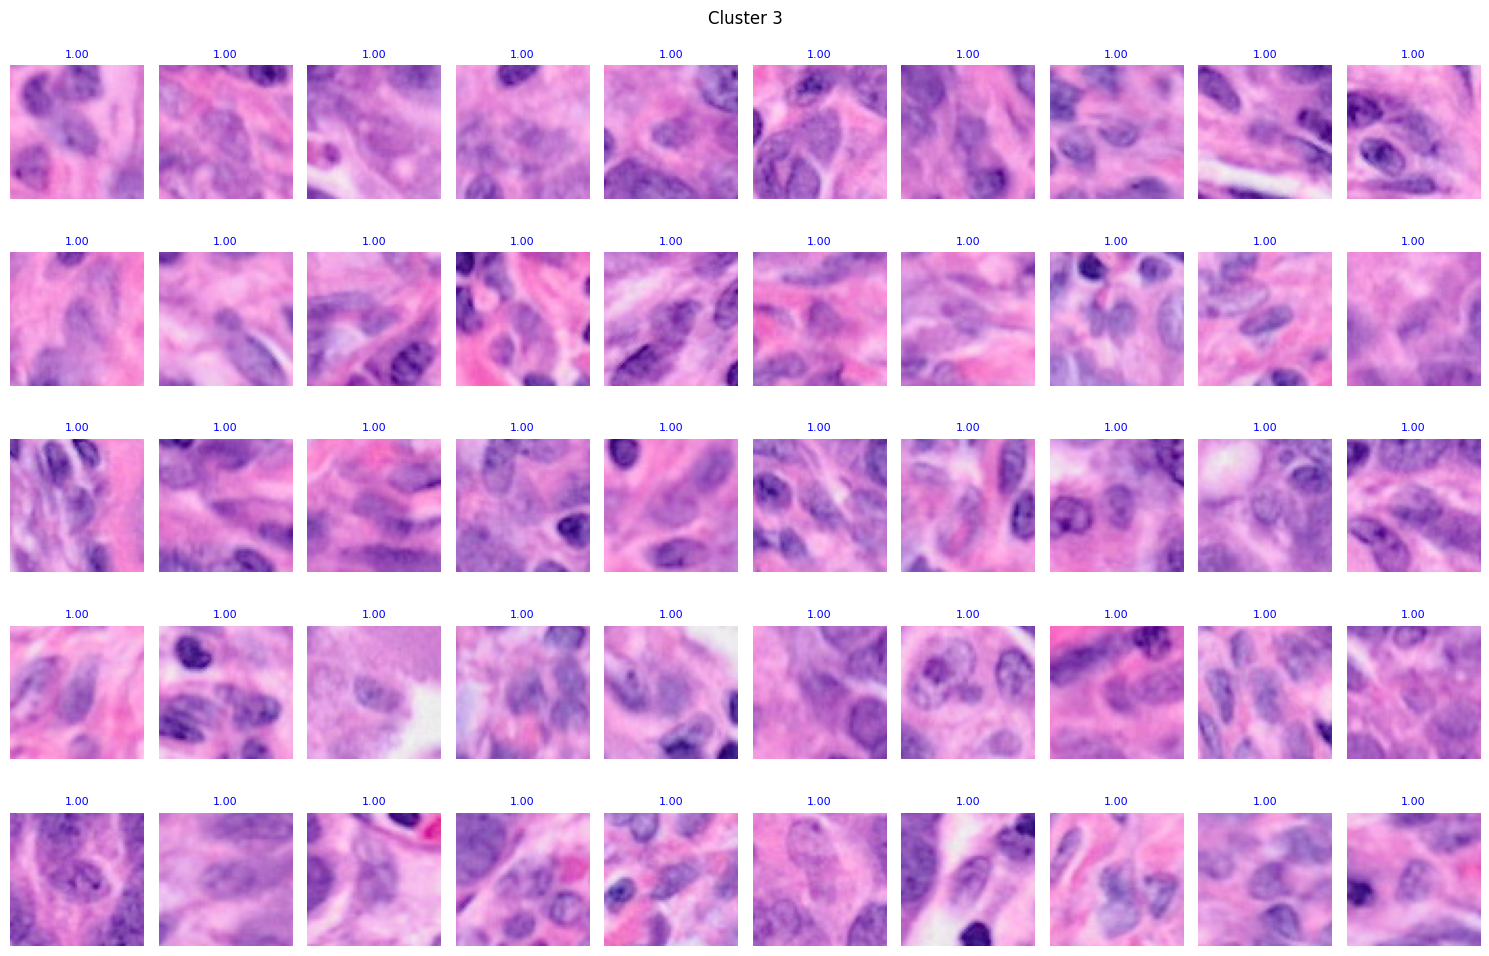

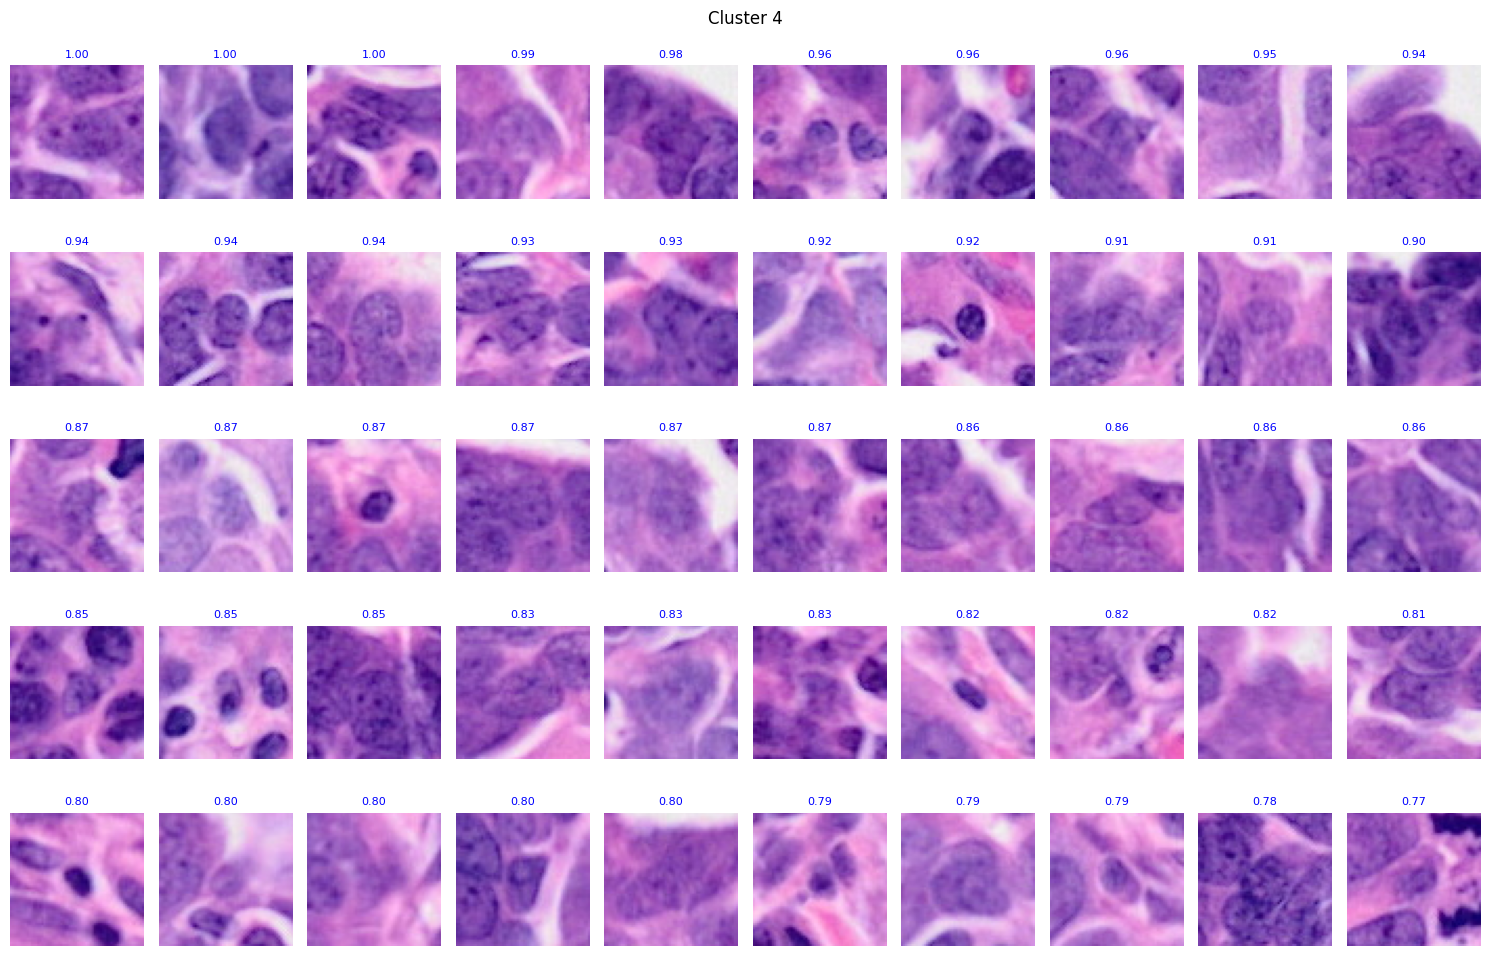

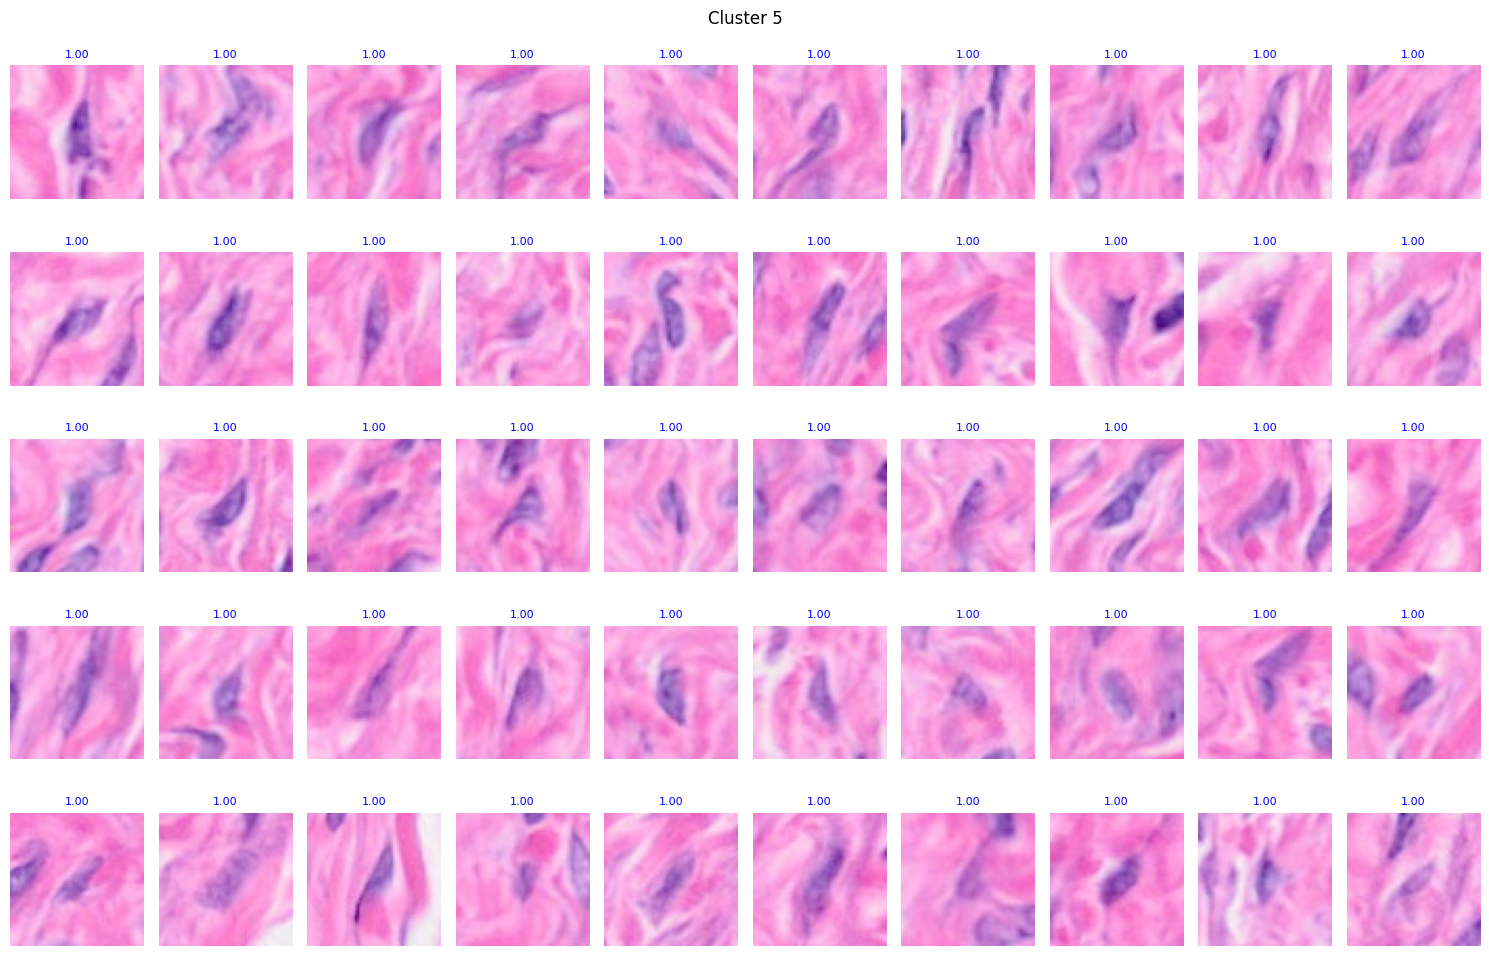

In [133]:
for ct in analyzer.ct_list:
    analyzer.plot_grid_celltype(cell_type=ct, n=50, selection="max", display=True)

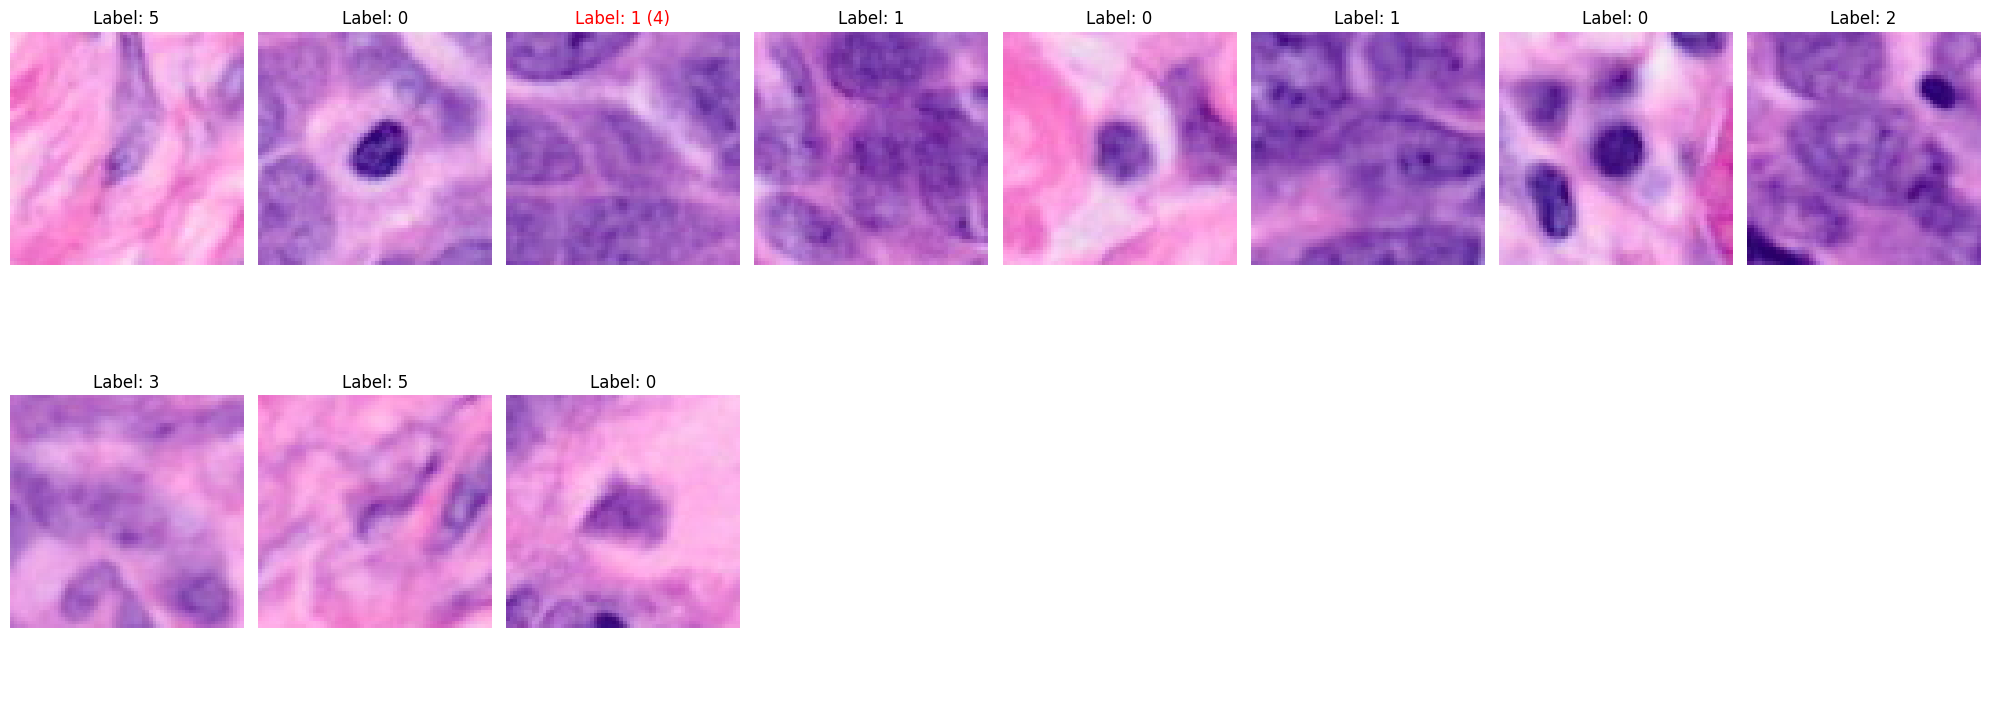

In [138]:
analyzer.plot_mosaic_cells(spot_id='212')

In [139]:
analyzer.evaluate_spot_predictions()

{'Spearman Correlation': 0.7894001531164184,
 'Pearson Correlation': 0.8008770223213578,
 'Weighted MSE': 0.0014340606531144538,
 'MSE': 0.011203405130267926,
 'Weighted MAE': 0.010258202165625164,
 'MAE': 0.07038127575921375,
 'R^2 Score': -0.08529713124474349,
 'Balanced Accuracy': 0.5275242334564368,
 'Weighted F1 Score': 0.792844329183408,
 'Weighted Precision': 0.9018201308897678,
 'Weighted Recall': 0.7296137339055794}

In [136]:
perf = analyzer.evaluate_cell_predictions()
perf

{'Global Accuracy': 0.7289131920710868,
 'Balanced Accuracy': 0.704153899819699,
 'Weighted F1 Score': 0.6880356167785534,
 'F1 Score (Per Class)': {'Cluster 0': 0.6928657799274486,
  'Cluster 1': 0.8186432856483618,
  'Cluster 2': 0.9428197293758184,
  'Cluster 3': 0.6426193118756937,
  'Cluster 4': 0.08828250401284109,
  'Cluster 5': 0.9361702127659575},
 'Weighted Precision': 0.734088208365885,
 'Precision (Per Class)': {'Cluster 0': 0.5330232558139535,
  'Cluster 1': 0.8431558935361216,
  'Cluster 2': 0.9183673469387755,
  'Cluster 3': 0.8552437223042836,
  'Cluster 4': 0.39568345323741005,
  'Cluster 5': 0.9674952198852772},
 'Weighted Recall': 0.7289131920710868,
 'Recall (Per Class)': {'Cluster 0': 0.9896373056994818,
  'Cluster 1': 0.7955156950672646,
  'Cluster 2': 0.968609865470852,
  'Cluster 3': 0.5146666666666667,
  'Cluster 4': 0.04968383017163505,
  'Cluster 5': 0.9068100358422939},
 'Confusion Matrix': array([[1719,    0,    0,    7,   10,    1],
        [ 115,  887,   

In [137]:
pd.DataFrame(perf["Confusion Matrix"], index=analyzer.ct_list, columns=analyzer.ct_list)

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5
Cluster 0       1719          0          0          7         10          1
Cluster 1        115        887         79          9         25          0
Cluster 2          3         30       1080          0          2          0
Cluster 3        402         54         13        579         45         32
Cluster 4        941         81          4         25         55          1
Cluster 5         45          0          0         57          2       1012

In [294]:
import numpy as np
global_proportions = np.array([0.1, 0.1, 0.1, 0.7])
weights = 1.0 / global_proportions
weights /= weights.sum()
weights = torch.tensor(weights)

outputs = torch.tensor([[0.1, 0.2, 0.2, 0.4], [0.1, 0.3, 0.2, 0.4]])

In [265]:
weights

tensor([0.3182, 0.3182, 0.3182, 0.0455], dtype=torch.float64)

In [276]:
max_probs, max_indices = outputs.max(dim=1)
max_weights = weights[max_indices]
max_prob_loss = -torch.mean(max_weights * torch.log(max_probs))
max_prob_loss

tensor(0.0335, dtype=torch.float64)